# Train a Classifier to detect traffic lights

##### Udacity Self-Driving Car Nanodegree
##### project system integration
##### team vulture

This approach follows very closely the one documented in https://github.com/cena0805/ros-traffic-light-classifier as this is almost what we need.

Rainer Bareiss, V0.2, August 20th, 2017, Lago Maggiore

## 1 imports

In [372]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
#from visual_callbacks import AccLossPlotter
import model
import numpy as np
import glob
import os
from PIL import Image
import collections
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 2 parameters

In [373]:
batch_size = 64
nb_epoch = 25 #3 #25
nb_train_samples = 200

## 3 load & explore model

In [374]:
# original model from https://github.com/cena0805/ros-traffic-light-classifier
model = model.get_model()

In [375]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_37 (Convolution2D) (None, 64, 64, 32)    896         convolution2d_input_20[0][0]     
____________________________________________________________________________________________________
activation_55 (Activation)       (None, 64, 64, 32)    0           convolution2d_37[0][0]           
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 62, 62, 32)    9248        activation_55[0][0]              
____________________________________________________________________________________________________
activation_56 (Activation)       (None, 62, 62, 32)    0           convolution2d_38[0][0]           
___________________________________________________________________________________________

In [376]:
# TODO: iplement squeezenet and compare accuracy & runtime for small data set

In [377]:
# ...

## 4 load data and split into training, validate and test data

In [378]:
# set data pathes
# input & output folder
mydir_in = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/00-team_vulture/SDC-System-Integration/classifier/'
mydir_out = '/Users/rainerbareiss/Downloads/traffic_light_images/'
#mydir_in = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/00-team_vulture/SDC-System-Integration/classifier'



In [379]:
#mydir = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/90-sample_classifier/model'
#myfiles = glob.glob(mydir+"/images/*/*.*")

myfiles = glob.glob(mydir_in+"/images/*/*.*")

#print(myfiles)
train_samples, validation_samples = train_test_split(myfiles, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

34972
8744


## 5 prepare data fro training 

### input

/images:
    /red
    /green
    /unknown
    
### output (augmented)

/train:
    /red
    /green
    /unknown
    
/test:
    /red
    /green
    /unknown

### store training data into separate folder

In [200]:
# https://stackoverflow.com/questions/3397157/how-to-read-a-raw-image-using-pil

In [201]:
for ifile in train_samples:
    # read data
    file = Image.open(ifile)
    imgSize = file.size
    rawData = file.tobytes()
    
    # get class & file name
    classdir = ifile.split("/")[-2]   # class name
    classname = ifile.split("/")[-1]  # name of the image file
    #print(classdir + ' ---> ' + classname)
    
    # generate new file names
    ofile = mydir_out + 'train/' + classdir + '/' + classname
    #print(ofile)
    
    # save in new folder
    img = Image.frombytes('RGB', imgSize, rawData)
    img.save(ofile)
    #print(ifile)

In [380]:
datagen = ImageDataGenerator(width_shift_range=.2, height_shift_range=.2, shear_range=0.05, zoom_range=.1,
                             fill_mode='nearest', rescale=1. / 255)
train_image_data_gen = datagen.flow_from_directory(mydir_out+'train', target_size=(64, 64), classes=['green', 'red', 'unknown'],
                                             batch_size=batch_size)
print("number of image samples: ",train_image_data_gen.nb_sample)

Found 34972 images belonging to 3 classes.
number of image samples:  34972


### store test data into separate folder

In [390]:
y_ground_truth = []

for ifile in validation_samples:
    # read data
    file = Image.open(ifile)
    imgSize = file.size
    rawData = file.tobytes()
    
    # get class & file name
    classdir = ifile.split("/")[-2]   # class name
    classname = ifile.split("/")[-1]  # name of the image file
    #print(classdir + ' ---> ' + classname)
    
    # generate new file names
    ofile = mydir_out + 'test/' + classdir + '/' + classname
    #print(ofile)
    
    # save in new folder
    img = Image.frombytes('RGB', imgSize, rawData)
    img.save(ofile)
    #print(ifile)
    
    # generate vector of ground_truth
    if (classdir == 'green'): y_ground_truth.append([1,0,0])
    if (classdir == 'red'): y_ground_truth.append([0,1,0])
    if (classdir == 'unknown'): y_ground_truth.append([0,0,1])

In [382]:
test_image_data_gen = datagen.flow_from_directory(mydir_out+'test', target_size=(64, 64), classes=['green', 'red', 'unknown'],
                                             batch_size=batch_size)
print("number of image samples: ",test_image_data_gen.nb_sample)

Found 8744 images belonging to 3 classes.
number of image samples:  8744


## 6 train model

In [383]:
# test model with less data
# model.fit_generator(train_image_data_gen, nb_epoch=nb_epoch, samples_per_epoch=nb_train_samples)

# full model
model.fit_generator(train_image_data_gen, nb_epoch=nb_epoch, samples_per_epoch=train_image_data_gen.nb_sample)

Epoch 1/25
34972/34972 [==============================] - 809s - loss: 0.2967 - acc: 0.9133      

## 7 save model

In [384]:
model.save('xxx_traffic_lights_classifier_epoch25.h5')

## 8 predict 

In [385]:
def reshape_image(image):
  x = img_to_array(image.resize((64, 64), Image.ANTIALIAS))
  return x[None, :]

def show(filename):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    #image = Image.open(filename)
    #image.show()
    %pylab inline
    img=mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()

model_predict = load_model('traffic_lights_classifier_epoch25.h5')

In [386]:
# Load Example Image
green = load_img(mydir_in + 'images_from_simulator/sampleout1.jpg')
samp = load_img(mydir_in + 'images_from_simulator/sim03.png')

# TODO: scale & crop before prediction!!!
#my_prob = model_predict.predict(reshape_image(green))
my_prob = model_predict.predict(reshape_image(samp))


print(my_prob)
print(my_prob[0][0])

[[ 0.  1.  0.]]
0.0


Populating the interactive namespace from numpy and matplotlib


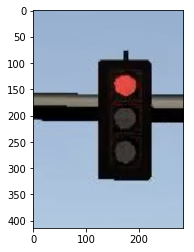

[[ 0.  1.  0.]]


In [364]:
# sample image
my_sample = 'images_from_simulator/sim03.png'

# show cropped image
%pylab inline
img=mpimg.imread(my_sample)
imgplot = plt.imshow(img)
plt.show()

# predict color of traffic light
samp = load_img(mydir_in + my_sample)
my_prob = model_predict.predict(reshape_image(samp))
print(my_prob) # green / red / unknown

## 9 analyse performance of model

In [398]:
# apply prediction over all test data 
myfiles = glob.glob(mydir_out+"/test/*/*.*")
my_pred = []

for ifile in myfiles:
    my_img = load_img(ifile)
    my_prob = model_predict.predict(reshape_image(my_img))
    my_pred.append([my_prob[0][0],my_prob[0][1],my_prob[0][2]])
    #print(max(my_prob))
print(len(my_pred))

8744


In [407]:
# generate array of indices showing the class number of prediction
my_pred_ind = []

for ipred in my_pred:
        imax = np.argwhere(ipred == np.amax(ipred))
        ##print(ipred, "     ", imax[0][0])
        my_pred_ind.append(imax[0][0])
        #if (imax[0][0] != 2): my_pred_ind.append(imax[0][0])
        
print(len(my_pred_ind))

8744


In [395]:
#print(y_ground_truth)

In [405]:
# generate array of indices showing the ground truth class
my_true_ind = []

for itrue in y_ground_truth:
        imax = np.argwhere(itrue == np.amax(itrue))
        ##print(ipred, "     ", imax[0][0])
        my_true_ind.append(imax[0][0])
        #if (imax[0][0] != 2): my_true_ind.append(imax[0][0])
        
print(len(my_true_ind))

8744


In [409]:
# check elementwise for equality and store result in vector
comp = np.equal(my_pred_ind, my_true_ind)
print("array of comparision: ",comp)

# count occurences of true
collections.Counter(comp)
mytrues = Counter(comp)
if (len(comp) != 0): 
    print("Accuracy of predicting new traffic lights from simulator = ", mytrues[1]/len(comp)*100,"%")
else:
    print("no red or green lights detected")

array of comparision:  [False False False ..., False False False]
Accuracy of predicting new traffic lights from simulator =  44.213174748398906 %
